### SETUP INICIAL DO PROJETO

In [1]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account

# Carrega o .env: onde estão as credenciais do projeto/repositório
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")

# Detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"

# Parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
# Tables_to_process: lista de tabelas que serão processadas
# Output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.raw_data.sales-salesorderheader"       
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.raw_data_cleaned"

# Configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


In [2]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.raw_data.sales-salesorderheader']


In [3]:
# Nome do dataset no Bigquery com os dados brutos (.csv) extraídos pelo Meltano 
dataset_id = 'raw_data'
print(dataset_id)

# Lista de tabelas do dataset raw_data no Bigquery
tables = client.list_tables('raw_data')
print("Tabelas disponíveis:")
for table in tables:
    print(table.table_id)

raw_data
Tabelas disponíveis:
humanresources-employee
person-address
person-businessentity
person-person
person-stateprovince
production-location
production-product
production-productcategory
production-productinventory
production-productsubcategory
sales-customer
sales-salesorderdetail
sales-salesorderheader
sales-salesterritory
sales-store


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [4]:
# Configuração para que o df exiba todas as colunas e todas as linhas completas, e também, exiba o formato numérico com 2 dígitos após a vírgula

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [5]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    # Nome da tabela com substituição de '-' por '_'
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    # Ler os dados da tabela do BigQuery para um df
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    # Armazenar o df no dicionário
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")

# Print de validação
print("Todas as tabelas foram processadas com sucesso!")


Processando tabela: desafioadventureworks-446600.raw_data.sales-salesorderheader
Lendo os dados do BigQuery...
Tabela sales_salesorderheader processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [6]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: sales_salesorderheader


In [7]:
# Atribuir o df a uma variável com nome mais simples
sales_salesorderheader = df_processados['sales_salesorderheader']

print(f"Colunas: {sales_salesorderheader.shape[1]}\nLinhas: {sales_salesorderheader.shape[0]}")

Colunas: 25
Linhas: 503440


In [8]:
# Identificar duplicadas com base em 'salesorderid'
duplicadas = sales_salesorderheader[
    sales_salesorderheader.duplicated(subset=['salesorderid'], keep=False)
]

# Verificar se existem duplicadas
if not duplicadas.empty:
    # Ordenar duplicadas por 'salesorderid' e 'modifieddate'
    duplicadas_ordenadas = duplicadas.sort_values(by=['salesorderid', 'modifieddate'])

    # Exibir duplicadas ordenadas
    print("duplicadas ordenadas:")
    print(duplicadas_ordenadas)
else:
    print("Não foram encontradas duplicadas.")

duplicadas ordenadas:
        salesorderid  revisionnumber                 orderdate                   duedate                  shipdate  status  onlineorderflag purchaseordernumber   accountnumber  customerid  salespersonid  territoryid  billtoaddressid  shiptoaddressid  shipmethodid  creditcardid creditcardapprovalcode  currencyrateid  subtotal  taxamt  freight  totaldue comment                               rowguid              modifieddate
7904           43659               8 2011-05-31 00:00:00+00:00 2011-06-12 00:00:00+00:00 2011-06-07 00:00:00+00:00       5            False         PO522145787  10-4020-000676       29825            279            5              985              985             5         16281          105041Vi84182            <NA>  20565.62 1971.51   616.10  23153.23    None  79b65321-39ca-4115-9cba-8fe0903e12e6 2011-06-07 00:00:00+00:00
39369          43659               8 2011-05-31 00:00:00+00:00 2011-06-12 00:00:00+00:00 2011-06-07 00:00:00+00:00       5    

In [9]:
# Remover duplicadas mantendo a última ocorrência com base em 'modifieddate', pois ela que indica a data da última modificação nos dados
# Importante, pois se houver erro na ingestão (duplicação), mantém os dados integros.

sales_salesorderheader = sales_salesorderheader.drop_duplicates(subset=['salesorderid'], keep='last')

print(f"Linhas após remover duplicadas (baseando-se na última 'modifieddate'): {len(sales_salesorderheader)}")

#bkp dos dados brutos
raw_data_bkp_2_sem_duplicadas = sales_salesorderheader.copy()


#doc: bkp = backup (cópia)

Linhas após remover duplicadas (baseando-se na última 'modifieddate'): 31465


In [10]:
# Ordenar e exibir o df por 'salesorderid'
sales_salesorderheader = sales_salesorderheader.sort_values(by=['salesorderid'])

print(sales_salesorderheader)

        salesorderid  revisionnumber                 orderdate                   duedate                  shipdate  status  onlineorderflag purchaseordernumber   accountnumber  customerid  salespersonid  territoryid  billtoaddressid  shiptoaddressid  shipmethodid  creditcardid creditcardapprovalcode  currencyrateid  subtotal  taxamt  freight  totaldue comment                               rowguid              modifieddate
479879         43659               8 2011-05-31 00:00:00+00:00 2011-06-12 00:00:00+00:00 2011-06-07 00:00:00+00:00       5            False         PO522145787  10-4020-000676       29825            279            5              985              985             5         16281          105041Vi84182            <NA>  20565.62 1971.51   616.10  23153.23    None  79b65321-39ca-4115-9cba-8fe0903e12e6 2011-06-07 00:00:00+00:00
479880         43660               8 2011-05-31 00:00:00+00:00 2011-06-12 00:00:00+00:00 2011-06-07 00:00:00+00:00       5            False       PO

In [11]:
sales_salesorderheader.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31465 entries, 479879 to 483209
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   salesorderid            31465 non-null  Int64              
 1   revisionnumber          31465 non-null  Int64              
 2   orderdate               31465 non-null  datetime64[us, UTC]
 3   duedate                 31465 non-null  datetime64[us, UTC]
 4   shipdate                31465 non-null  datetime64[us, UTC]
 5   status                  31465 non-null  Int64              
 6   onlineorderflag         31465 non-null  boolean            
 7   purchaseordernumber     3806 non-null   object             
 8   accountnumber           31465 non-null  object             
 9   customerid              31465 non-null  Int64              
 10  salespersonid           3806 non-null   Int64              
 11  territoryid             31465 non-null  

In [12]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in sales_salesorderheader.columns:   
    missing_rows = sales_salesorderheader[sales_salesorderheader[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")



#doc: algumas colunas apresentam valores ausentes:      

# purchaseordernumber: 27659 linhas ausentes, aprox. 88% de dados ausentes - coluna deletada
# salespersonid: 27659 linhas ausentes, aprox. 88% de dados ausentes - coluna deletada
# creditcardid: 1131 linhas ausentes, mantive a coluna por ser ID Coluna 
# creditcardapprovalcode: 1131 linhas ausentes, mantive a coluna
# currencyrateid: 17489 linhas ausentes, aprox. 56% de dados ausentes - coluna deletada
# comment: 31465 linhas ausentes, 100% de dados ausentes - coluna deletada         
 

Coluna 'salesorderid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'salesorderid'.

Coluna 'revisionnumber': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'revisionnumber'.

Coluna 'orderdate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'orderdate'.

Coluna 'duedate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'duedate'.

Coluna 'shipdate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'shipdate'.

Coluna 'status': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'status'.

Coluna 'onlineorderflag': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'onlineorderflag'.

Coluna 'purchaseordernumber': 27659 linhas ausentes.
Exibindo as primeiras linhas com valores ausentes em 'purchaseordernumber':
        salesorderid  revisionnumber                 orderdate                   duedate                  shipdate  status  onlineorderflag purchaseordernumber   accountnumber  customerid  salespersonid  territoryid  b

In [13]:
#deletar colunas com muitos valores ausentes
sales_salesorderheader = sales_salesorderheader.drop(columns=['purchaseordernumber', 'salespersonid', 'currencyrateid', 'comment'])

print("Colunas restantes após remoção:")
print(sales_salesorderheader.columns)

Colunas restantes após remoção:
Index(['salesorderid', 'revisionnumber', 'orderdate', 'duedate', 'shipdate', 'status', 'onlineorderflag', 'accountnumber', 'customerid', 'territoryid', 'billtoaddressid', 'shiptoaddressid', 'shipmethodid', 'creditcardid', 'creditcardapprovalcode', 'subtotal', 'taxamt', 'freight', 'totaldue', 'rowguid', 'modifieddate'], dtype='object')


In [14]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.

valores_unicos = sales_salesorderheader.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)



Valores únicos incluindo NaN:
salesorderid              31465
revisionnumber                2
orderdate                  1124
duedate                    1124
shipdate                   1124
status                        1
onlineorderflag               2
accountnumber             19119
customerid                19119
territoryid                  10
billtoaddressid           19119
shiptoaddressid           19119
shipmethodid                  2
creditcardid              18385
creditcardapprovalcode    30335
subtotal                   4747
taxamt                     4745
freight                    4744
totaldue                   4754
rowguid                   31465
modifieddate               1124
dtype: int64


In [15]:
#verificar informações do df
sales_salesorderheader.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31465 entries, 479879 to 483209
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   salesorderid            31465 non-null  Int64              
 1   revisionnumber          31465 non-null  Int64              
 2   orderdate               31465 non-null  datetime64[us, UTC]
 3   duedate                 31465 non-null  datetime64[us, UTC]
 4   shipdate                31465 non-null  datetime64[us, UTC]
 5   status                  31465 non-null  Int64              
 6   onlineorderflag         31465 non-null  boolean            
 7   accountnumber           31465 non-null  object             
 8   customerid              31465 non-null  Int64              
 9   territoryid             31465 non-null  Int64              
 10  billtoaddressid         31465 non-null  Int64              
 11  shiptoaddressid         31465 non-null  

In [16]:
#avaliando as variáveis qualitativas*

# Lista de colunas qualitativas para análise
coluna_qualitativa = ["status", "onlineorderflag", "territoryid", "shipmethodid"]

# Análise de valores para cada coluna qualitativa
for col in coluna_qualitativa:
    counts = sales_salesorderheader[col].value_counts().nlargest(10) 
    percentages = (counts / sales_salesorderheader.shape[0] * 100).map("{:.2f}%".format)
    summary = pd.DataFrame({"qtde.": counts, "%": percentages})
    print(f"Resumo para a coluna '{col}':")
    print(summary)
    print()



#doc*: variáveis qualitativas são um tipo de variável estatística que representam características ou atributos dos dados, sem serem medidas numericamente
#      no nosso caso, jobtitle, maritalstatus, gender, por exemplo

Resumo para a coluna 'status':
        qtde.        %
status                
5       31465  100.00%

Resumo para a coluna 'onlineorderflag':
                 qtde.       %
onlineorderflag               
True             27659  87.90%
False             3806  12.10%

Resumo para a coluna 'territoryid':
             qtde.       %
territoryid               
9             6843  21.75%
4             6224  19.78%
1             4594  14.60%
6             4067  12.93%
10            3219  10.23%
7             2672   8.49%
8             2623   8.34%
5              486   1.54%
3              385   1.22%
2              352   1.12%

Resumo para a coluna 'shipmethodid':
              qtde.       %
shipmethodid               
1             27659  87.90%
5              3806  12.10%



In [17]:
# Agrupar por 'territoryid' para calcular quantidade e proporção de pedidos online
territory_summary = sales_salesorderheader.groupby('territoryid')['onlineorderflag'].agg(
    qtde='count',
    online_percent=lambda x: x.mean() * 100
)

# Formatando a coluna de porcentagem
territory_summary['%'] = territory_summary['online_percent'].map("{:.2f}%".format)

# Selecionando as colunas desejadas e ordenando pela maior quantidade
territory_summary = territory_summary[['qtde', '%']].sort_values(by='qtde', ascending=False)

# Exibindo o resumo
print("Resumo por território (quantidade e % de pedidos online):")
print(territory_summary)


Resumo por território (quantidade e % de pedidos online):
             qtde       %
territoryid              
9            6843  98.17%
4            6224  87.93%
1            4594  88.33%
6            4067  82.99%
10           3219  94.16%
7            2672  92.96%
8            2623  94.70%
5             486   3.50%
3             385   2.34%
2             352   2.84%


Distribuição de métodos de envio por território:
shipmethodid     1    5
territoryid            
1             4058  536
2               10  342
3                9  376
4             5473  751
5               17  469
6             3375  692
7             2484  188
8             2484  139
9             6718  125
10            3031  188


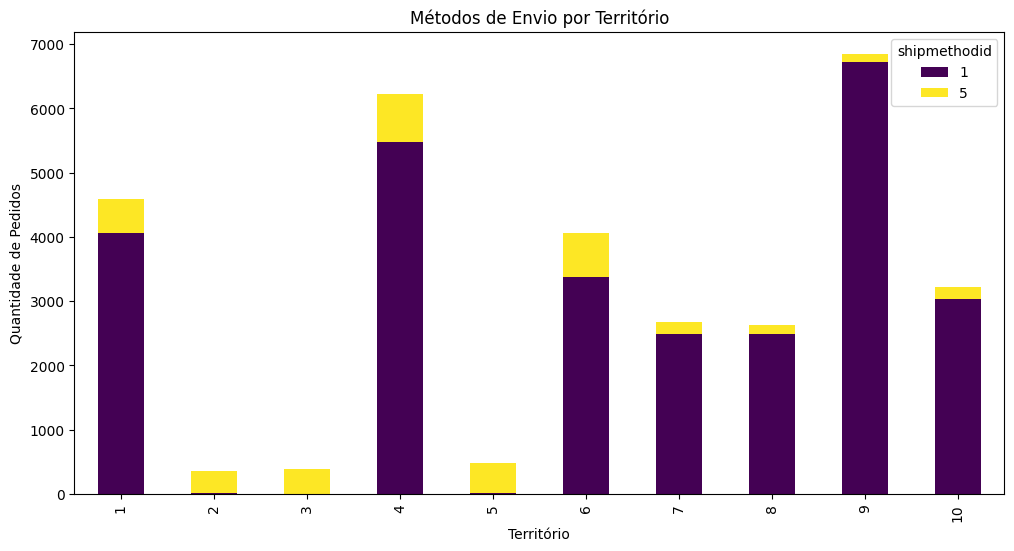

In [18]:
# Análise cruzada entre 'territoryid' e 'shipmethodid'
territory_ship = sales_salesorderheader.groupby(['territoryid', 'shipmethodid']).size().unstack(fill_value=0)
print("Distribuição de métodos de envio por território:")
print(territory_ship)

# Visualização
territory_ship.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title("Métodos de Envio por Território")
plt.xlabel("Território")
plt.ylabel("Quantidade de Pedidos")
plt.show()


Métodos de envio por tipo de pedido (online/offline):
shipmethodid         1     5
onlineorderflag             
False                0  3806
True             27659     0


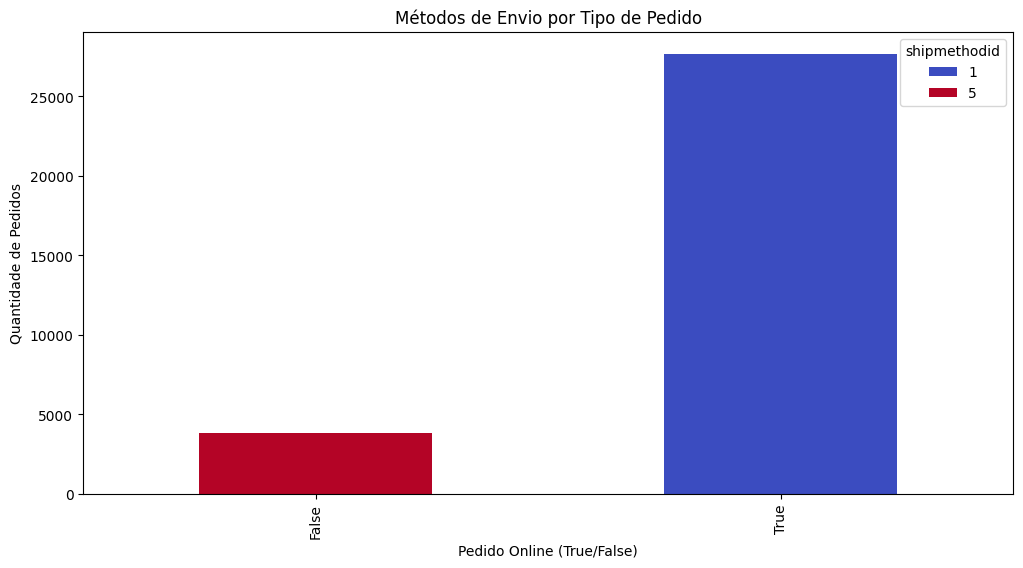

In [19]:
# Agrupar por 'onlineorderflag' e 'shipmethodid'
online_ship = sales_salesorderheader.groupby(['onlineorderflag', 'shipmethodid']).size().unstack(fill_value=0)
print("Métodos de envio por tipo de pedido (online/offline):")
print(online_ship)

# Visualização
online_ship.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title("Métodos de Envio por Tipo de Pedido")
plt.xlabel("Pedido Online (True/False)")
plt.ylabel("Quantidade de Pedidos")
plt.show()


Receita total por território:
territoryid
4    24184609.60
6    16355770.46
1    16084942.55
9    10655335.96
3     7909009.01
5     7879655.07
10    7670721.04
7     7251555.65
2     6939374.48
8     4915407.60
Name: subtotal, dtype: float64


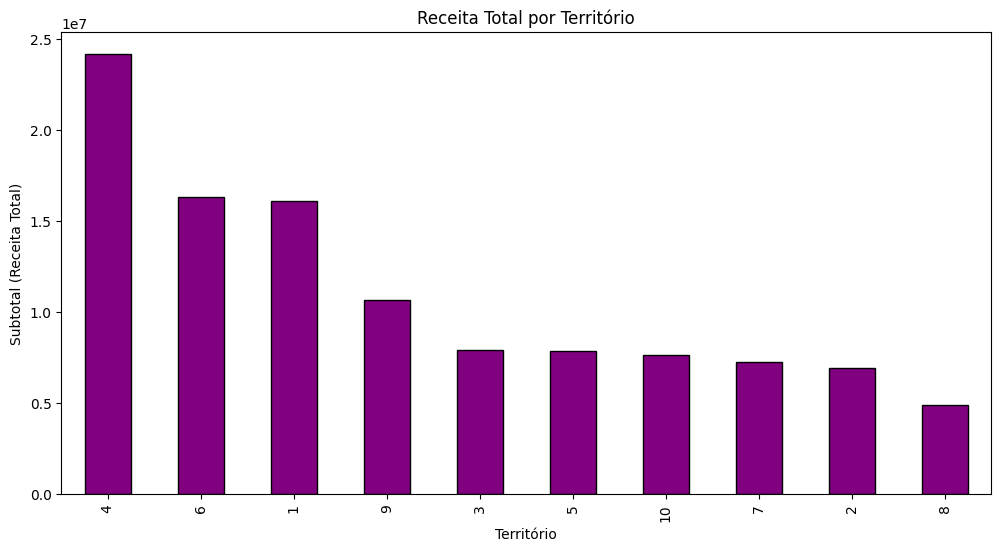

In [20]:
# Receita total por território
territory_revenue = sales_salesorderheader.groupby('territoryid')['subtotal'].sum().sort_values(ascending=False)
print("Receita total por território:")
print(territory_revenue)

# Visualização
territory_revenue.plot(kind='bar', figsize=(12, 6), color='purple', edgecolor='black')
plt.title("Receita Total por Território")
plt.xlabel("Território")
plt.ylabel("Subtotal (Receita Total)")
plt.show()


In [21]:
# Variáveis quantitativas*: estatísticas descritivas para verificar se ainda há o que ser feito antes de exportar os dados ao BigQuery

# Identificar colunas numéricas para análise de outliers
numeric_columns = ['subtotal', 'taxamt','freight', 'totaldue']

# Estatísticas Descritivas das colunas numéricas*
print(sales_salesorderheader[numeric_columns].describe())

# Cálculo de limites para outliers (IQR)**
for col in numeric_columns:
    q1 = sales_salesorderheader[col].quantile(0.25)
    q3 = sales_salesorderheader[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Exibir os limites
    print(f"\nColuna: {col}")
    print(f"Limite inferior: {lower_bound}, Limite superior: {upper_bound}")
    
    # Detecção e Análise de Outliers***
    outliers = sales_salesorderheader[(sales_salesorderheader[col] < lower_bound) | (sales_salesorderheader[col] > upper_bound)]
    print(f"Outliers detectados ({len(outliers)}):")
    print(outliers[[col]])


#doc*: variáveis quantitativas são um tipo de dado que pode ser representado por números e medidas objetivas, no nosso caso, vacationhours, sickleavehours, por exemplo
#doc*: realizar estatísticas descritivas para entender a centralidade e variação dos dados (valores médios, mínimos, máximos, etc.)
#doc**: calcular limites para identificar outliers (valores extremos que podem indicar erros ou casos excepcionais nos dados)
#doc***: verificar a existência de outliers para decidir ações como remoção, substituição ou tratamento, garantindo qualidade dos dados

#doc****: as colunas analisadas apresentam outliers, os outliers identificados parecem legítimos no contexto do AdventureWorks, refletindo compras em grande volume, 
#         produtos premium ou custos logísticos elevados. Resultando em não manipular tais colunas

       subtotal   taxamt  freight  totaldue
count  31465.00 31465.00 31465.00  31465.00
mean    3491.07   323.76   101.17   3916.00
std    11093.45  1085.05   339.08  12515.46
min        1.37     0.11     0.03      1.52
25%       56.97     4.56     1.42     62.95
50%      782.99    62.64    19.57    865.20
75%     2366.96   189.60    59.25   2615.49
max   163930.39 17948.52  5608.91 187487.83

Coluna: subtotal
Limite inferior: -3408.015000000001, Limite superior: 5831.945000000001
Outliers detectados (2118):
        subtotal
479879  20565.62
480358  32726.48
480359  28832.53
471975  24432.61
471976  14352.77
...          ...
489926  29703.31
475347  34063.82
480354  80450.38
475348  34123.67
479422  67059.64

[2118 rows x 1 columns]

Coluna: taxamt
Limite inferior: -273.0024, Limite superior: 467.1576
Outliers detectados (2230):
        taxamt
479879 1971.51
480358 3153.77
480359 2775.16
471975 2344.99
471976 1375.94
...        ...
489926 2833.71
475347 3266.67
480354 7735.15
475348 32

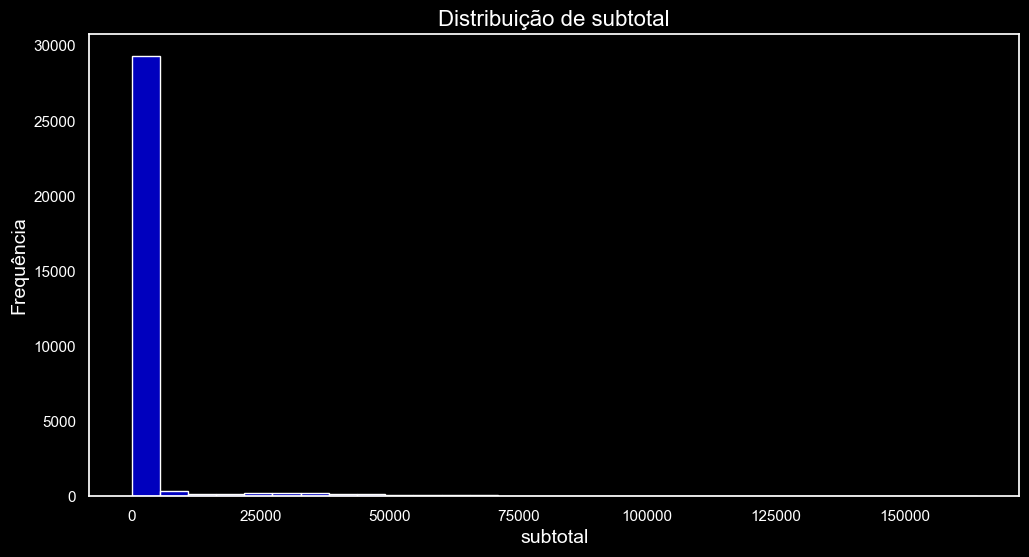

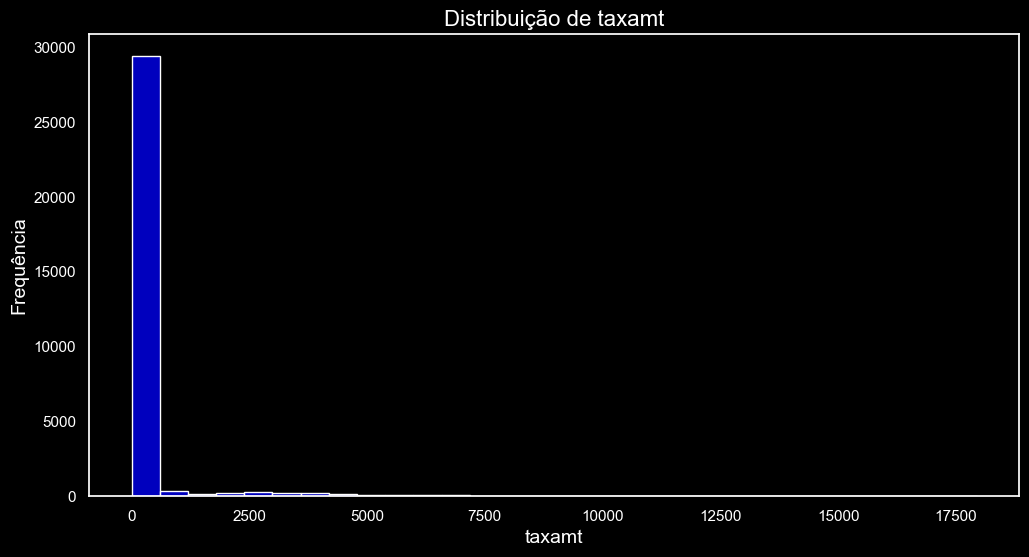

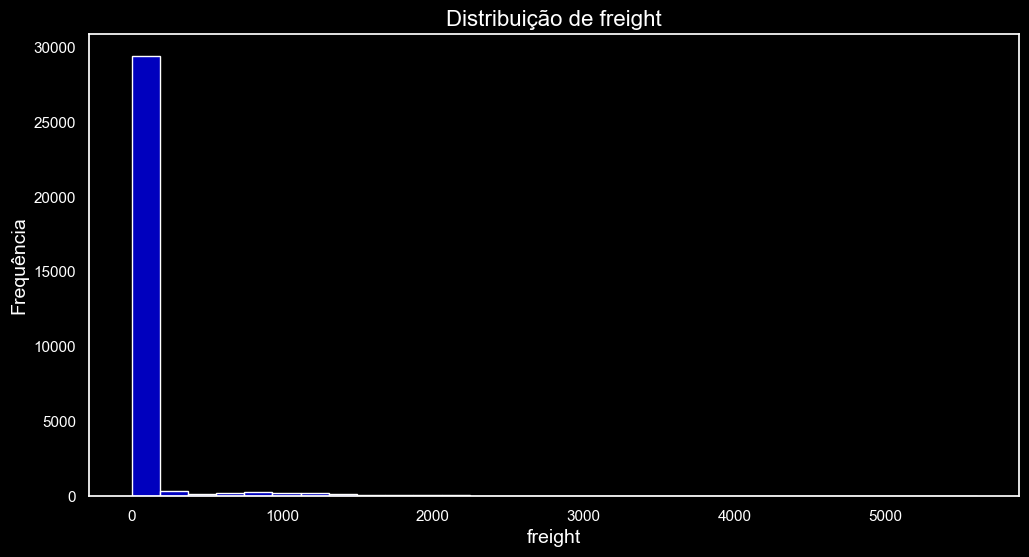

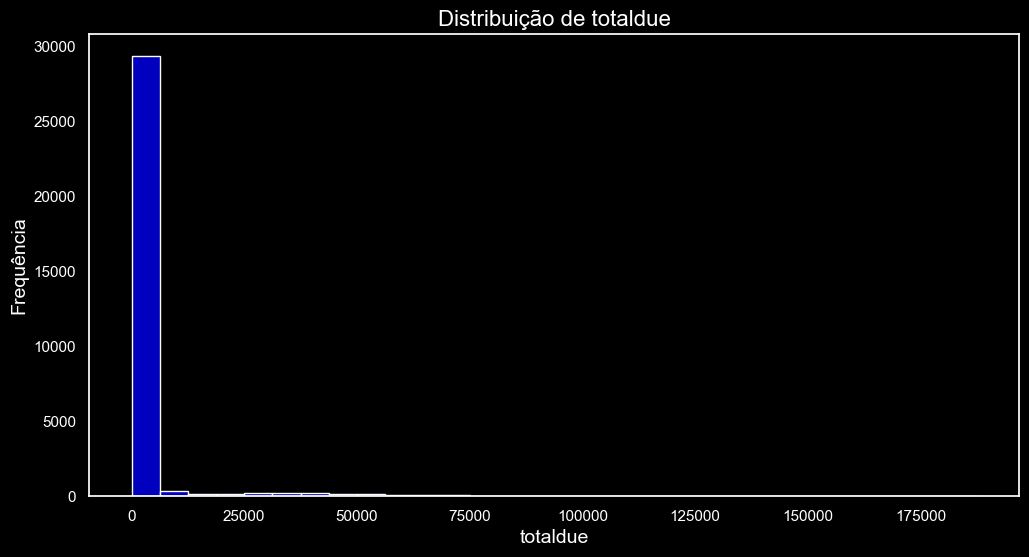

In [22]:
# Configurar o estilo do gráfico
sns.set(style='dark', rc={"axes.facecolor": "black", "figure.facecolor": "black"})

# Lista das colunas para análise
columns_to_plot = ['subtotal', 'taxamt', 'freight', 'totaldue']

# Criar histogramas (1 por linha)
for col in columns_to_plot:
    plt.figure(figsize=(12, 6))
    
    # Histograma
    ax = sns.histplot(
        sales_salesorderheader[col], bins=30, kde=False, color="blue", edgecolor="white"
    )
    
    # Título e rótulos
    plt.title(f'Distribuição de {col}', color='white', fontsize=16)
    plt.xlabel(col, color='white', fontsize=14)
    plt.ylabel("Frequência", color='white', fontsize=14)
    
    # Cor dos rótulos
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    # Remover grade
    ax.grid(False)
    
    # Exibir o gráfico
    plt.show()


In [23]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['sales_salesorderheader'] = sales_salesorderheader

In [24]:
sales_salesorderheader.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31465 entries, 479879 to 483209
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   salesorderid            31465 non-null  Int64              
 1   revisionnumber          31465 non-null  Int64              
 2   orderdate               31465 non-null  datetime64[us, UTC]
 3   duedate                 31465 non-null  datetime64[us, UTC]
 4   shipdate                31465 non-null  datetime64[us, UTC]
 5   status                  31465 non-null  Int64              
 6   onlineorderflag         31465 non-null  boolean            
 7   accountnumber           31465 non-null  object             
 8   customerid              31465 non-null  Int64              
 9   territoryid             31465 non-null  Int64              
 10  billtoaddressid         31465 non-null  Int64              
 11  shiptoaddressid         31465 non-null  

In [25]:
# Padronizar colunas com valores textuais
sales_salesorderheader['rowguid'] = sales_salesorderheader['rowguid'].str.strip().str.upper()

print(sales_salesorderheader.head())

#doc: padronizar as strings nessa etapa, contribui para a execução das demais etapas do pipeline

        salesorderid  revisionnumber                 orderdate                   duedate                  shipdate  status  onlineorderflag   accountnumber  customerid  territoryid  billtoaddressid  shiptoaddressid  shipmethodid  creditcardid creditcardapprovalcode  subtotal  taxamt  freight  totaldue                               rowguid              modifieddate
479879         43659               8 2011-05-31 00:00:00+00:00 2011-06-12 00:00:00+00:00 2011-06-07 00:00:00+00:00       5            False  10-4020-000676       29825            5              985              985             5         16281          105041Vi84182  20565.62 1971.51   616.10  23153.23  79B65321-39CA-4115-9CBA-8FE0903E12E6 2011-06-07 00:00:00+00:00
479880         43660               8 2011-05-31 00:00:00+00:00 2011-06-12 00:00:00+00:00 2011-06-07 00:00:00+00:00       5            False  10-4020-000117       29672            5              921              921             5          5618          115213Vi29411 

In [26]:

# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
    # Nome da tabela no BigQuery
    output_table = f"{output_dataset}.{table_name}"

    # Configurar job de exportação
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    # Exportar DataFrame para o BigQuery
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")

Tabela sales_salesorderheader exportada com sucesso para desafioadventureworks-446600.raw_data_cleaned.sales_salesorderheader.
